Environment: pytorch

# <font color='purple'>Convolutional Neural Network
In this notebook, we build and tune a convolutional neural network to classify the MNIST samples as one of 10 digits: 0-9.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import optuna
from optuna.trial import TrialState

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
os.chdir(r"C:\Users\sharo\Documents\Postgrad\My Data Science Portfolio\Classification - MNIST")
os.getcwd()

'C:\\Users\\sharo\\Documents\\Postgrad\\My Data Science Portfolio\\Classification - MNIST'

In [4]:
my_seed = 101

## <font color = 'blue'> Import Training Data & Reserve Mock-Test Set
Mock test dataset will not be used for hyperparameter tuning, but instead reserved for final evaluation of tuned model

In [5]:
def get_train_test_df(fp, label_colname, my_seed=None):
    """
    Function to import raw data, carry out pre-processing, and split into training and test datasets.
    Test data will be reserved for final evaluation of model performance (i.e. not for hyperparameter tuning)

    :param fp: filepath
    :param label_colname: name of column containing labels
    :param my_seed: integer to be used to fix random state for train_test_split

    :return: tuple of dataframes - training_df, test_df
    """

    # import data
    df = pd.read_csv(fp)

    # Standard scaling of features #TODO: try with and without
    scaler = StandardScaler()
    df[df.drop(columns=label_colname).columns] = scaler.fit_transform(df[df.drop(columns=label_colname).columns])

    # separate into training & test datasets.
    # Stratification is used to ensure training and test sets have representative proportions of all classes
    training_df, test_df = train_test_split(df, test_size=0.3, random_state=my_seed, stratify=df[label_colname])

    return training_df, test_df

In [6]:
# We use the unfiltered dataset as full set of pixels is required for CNN
training_df, mytest_df = get_train_test_df("train.csv", label_colname='label', my_seed = my_seed)

**Plot a few digits**   
Note that, unlike code for feed-forward neural network, definition of MyDataset below reassembles the flattened array of pixels for each image into a 28x28 px image to facilitate convolution later on.

We plot a few digits to check that this reassembly was done correctly

In [7]:
class MyDataset(Dataset): # inherits properties of pytorch Dataset class
    def __init__(self, dataframe, label_colname=None, blind_test=False):
        """
            Class initialisation
            :param dataframe: pandas dataframe including features and labels
            :param label_colname: name of column containing labels
            :param blind_test: Boolean. True means dataframe does not include labels (i.e. test set)
            """
        self.blind_test = blind_test

        if blind_test:  # for blind test (i.e. no label, self.labels does not exist)
            self.features = dataframe.to_numpy()
        else:
            self.features = dataframe.drop(columns=[label_colname]).to_numpy()
            self.labels = dataframe[label_colname].to_numpy()


    def __len__(self):
        """
        :return: length of dataset
        """
        return len(self.features)

    def __getitem__(self, idx):
        """
        Fetches features and label(s) at requested index
        :param idx: requested index
        :return: tuple of numpy arrays - batch_features, batch_labels. For blind test, return only batch_features
        """
        batch_features = self.features[idx, :]
        batch_images = np.zeros((1, 28, 28))  # initialise array for next datapoint. A 28x28px image
        for i in range(28):  # rows
            for j in range(28):  # columns
                x = i * 28 + j  # pixel (i,j) from the original img is located in column x of flattened img
                batch_images[0, i, j] = batch_features[x]

        if self.blind_test:
            return batch_images
        else:
            batch_labels = self.labels[idx]
            return batch_images, batch_labels

In [8]:
#format training dataframe as pytorch dataloader
check_dataset = MyDataset(training_df, 'label')
check_dataloader = DataLoader(check_dataset, batch_size=5, shuffle=True)

# get first batch of images and their labels
check_iter = iter(check_dataloader)
images, labels = next(check_iter)

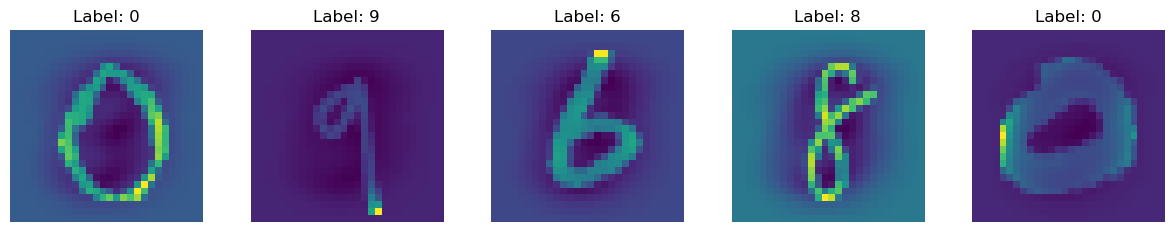

In [9]:
#plot
fig, ax = plt.subplots(figsize=(15, 2.5), ncols=5)
ax = ax.flatten()
for i in range(len(images)):
    ax[i].imshow(np.transpose(images[i], (1, 2, 0)))
    ax[i].axis('off')
    ax[i].set_title(f"Label: {labels[i].item()}")

## <font color = 'blue'>Train Model
**Tune Hyperparameters**

In [10]:
def set_parameters(trial):
    """
    Set parameters for neural network, optimisation algorithm etc.
    :param trial: Optuna trial object
    :return: dictionary of parameters:
            - n_conv_layers: number of convolution layers in neural network
            - out_ch_conv{i}: number of output channels in convolution layer i
            - kernel_conv{i}_even: kernel width in convolution layer i - even option
            - kernel_conv{i}_odd:                                      - odd option

            - n_linear_layers: number of linear layers in neural network
            - n_units_lin{i}: number of units in linear layer i
            - dropout_lin{i}: dropout probability for linear layer i

            - lr: learning rate
            - batch_size: batch size
            - n_epochs = number of epochs (i.e. number of passes through training data during optimisation)
    """
    trial.suggest_int("n_conv_layers", 1, 2)

    for i in range(trial.params['n_conv_layers']):
        trial.suggest_int(f'out_ch_conv{i}', 1, 20)
        trial.suggest_categorical(f'kernel_conv{i}_even', [2, 4, 6])
        trial.suggest_categorical(f'kernel_conv{i}_odd', [3, 5, 7])

    trial.suggest_int("n_linear_layers", 1, 3)

    for i in range(trial.params['n_linear_layers']):
        trial.suggest_int(f'n_units_lin{i}', 1, 200)
        trial.suggest_float(f"dropout_lin{i}", 0.1, 0.9)

    trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # TODO: try optimising these as well
    trial.suggest_int("batch_size", 10, 10)
    trial.suggest_int("n_epochs", 5, 5)
    trial.suggest_categorical("optimizer",["SGD"])

    my_params = trial.params

    return my_params

In [11]:
def define_model(my_params):
    """Defines convolutional neural network based on set parameters
    :param my_params: dictionary of parameters (see set_parameters() for full list)
    """

    layers = []

    # Define Convolution Layers
    in_ch = 1  # number of input channels = no. of channels in feature matrix = 1
    img_width = 28 # number of px along length & width of feature matrix
    for i in range(my_params['n_conv_layers']):
        # convolution layer
        out_ch = my_params[f'out_ch_conv{i}']  # number of output channels for this layer
        # for even image width use odd kernel width so that resulting img width is divisible by 2 during pooling
        if (img_width % 2) == 0:
            kernel_size = my_params[f'kernel_conv{i}_odd']
        else:
            kernel_size = my_params[f'kernel_conv{i}_even']
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size))

        layers.append(nn.ReLU())  # activation function
        layers.append(nn.MaxPool2d(2, 2))  # pooling layer

        in_ch = out_ch  # no. of input channels for next layer = no. of output channels from this layer
        img_width = int((img_width-(kernel_size-1))/2)

    layers.append(nn.Flatten(start_dim=1))  # flatten all dimensions except batch

    # Define Linear Layers
    in_features = in_ch * img_width * img_width
    for i in range(my_params['n_linear_layers']):
        # linear layer
        out_features = my_params[f'n_units_lin{i}']
        layers.append(nn.Linear(in_features, out_features))

        layers.append(nn.ReLU())  # activation function

        #drop-out regularisation
        p = my_params[f"dropout_lin{i}"]
        layers.append(nn.Dropout(p))

        in_features = out_features  # no. of inputs for next layer = no. of outputs of this layer

    layers.append(nn.Linear(in_features, 10))  # output layer

    return nn.Sequential(*layers)

In [12]:
def get_train_val_dataloader(training_df, my_batchsize, label_colname, my_seed = None):
    """
    Function to split training data into training and validation subsets and format as dataloaders
    Model performance on validation set will be used for hyperparameter tuning.

    :param training_df: dataframe with full set of training data
    :param my_batchsize: batch size for pytorch DataLoader
    :param label_colname: name of column containing labels
    :param my_seed: optional integer to fix train test split random state

    :return: tuple of pytorch DataLoaders - train_dataloader, val_dataloader
    """

    # separate into training & validation datasets
    train_data, val_data = train_test_split(training_df, test_size = 0.2, random_state = my_seed, stratify=training_df[label_colname])

    #format as pytorch dataloader
    train, val = MyDataset(train_data, label_colname), MyDataset(val_data, label_colname)
    train_dataloader = DataLoader(train, batch_size=my_batchsize, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=my_batchsize)

    return train_dataloader, val_dataloader

In [13]:
def count_correct(predictions, y):
    """
    Counts number of correct predictions in a batch

    :param predictions: 1D tensor with predictions
    :param y: 1D tensor with true classes

    :return: number of correct predictions (pred==y)
    """
    predictions = predictions.numpy()
    y = y.numpy()

    n_correct = (predictions == y).sum()

    return n_correct

In [14]:
def objective(trial):
    """
    Objective for Optuna to optimise
    :param trial: Optuna trial object
    :return: accuracy - fraction of correctly labelled validation points. This is what Optuna seeks to maximise
    """

    #set parameters
    my_params = set_parameters(trial)

    # Instantiate model
    model = define_model(my_params)

    # Instantiate optimizer
    optimizer_name = my_params['optimizer']
    lr = my_params['lr']
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # get data
    train_dataloader, val_dataloader = get_train_val_dataloader(training_df,
                                                                my_batchsize=my_params['batch_size'],
                                                                label_colname='label')

    # train model
    for epoch in range(my_params['n_epochs']):

        #train
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            # X and y are tensors. X.size() = (batch_size,n_features), y.size()=(batch_size,)
            # set datatype for compatibility with nn.
            X = X.float()
            y = y.long()

            # calculate model output and resulting loss
            model_output = model(X)  # tensor. size=(batch_size x n_classes)
            loss_fn = nn.CrossEntropyLoss() # instantiate loss function
            loss = loss_fn(model_output, y)

            # Backpropagation to update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # validate. We do this at each epoch to facilitate pruning:
        # i.e. early termination of trials which are clearly not going to be optimum
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_dataloader):
                X = X.float()
                y = y.long()

                # calculate model output and total number of correct predictions for this batch
                model_output = model(X)
                pred = torch.argmax(model_output, dim=1)  # prediction = class with highest output value
                correct += count_correct(pred, y)

        accuracy = correct / len(val_dataloader.dataset)

        # report accuracy to allow Optuna to decide whether to prune this trial
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy  # return final validation accuracy after all epochs (unless pruned)

In [15]:
# instantiate optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
# Optimise hyperparameters will try {n_trials} param combinations or till {timeout} seconds is hit
study.optimize(objective, n_trials=100)  # , timeout=600)

[I 2023-01-09 12:58:57,743] A new study created in memory with name: no-name-5a5bdf9d-81df-4bd5-bce4-dbca3438b459
[I 2023-01-09 13:00:49,585] Trial 0 finished with value: 0.4437074829931973 and parameters: {'n_conv_layers': 1, 'out_ch_conv0': 18, 'kernel_conv0_even': 2, 'kernel_conv0_odd': 5, 'n_linear_layers': 3, 'n_units_lin0': 82, 'dropout_lin0': 0.6551025614650803, 'n_units_lin1': 73, 'dropout_lin1': 0.8768654008802214, 'n_units_lin2': 89, 'dropout_lin2': 0.4101680331994084, 'lr': 0.0018316249889512787, 'batch_size': 10, 'n_epochs': 5, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.4437074829931973.
[I 2023-01-09 13:02:24,311] Trial 1 finished with value: 0.9217687074829932 and parameters: {'n_conv_layers': 1, 'out_ch_conv0': 3, 'kernel_conv0_even': 6, 'kernel_conv0_odd': 5, 'n_linear_layers': 3, 'n_units_lin0': 182, 'dropout_lin0': 0.17312337412644663, 'n_units_lin1': 127, 'dropout_lin1': 0.6682209863018902, 'n_units_lin2': 49, 'dropout_lin2': 0.18205458768048421, 'lr': 0.0024

[I 2023-01-09 13:35:52,734] Trial 36 pruned. 
[I 2023-01-09 13:36:15,582] Trial 37 pruned. 
[I 2023-01-09 13:38:02,765] Trial 38 finished with value: 0.9811224489795919 and parameters: {'n_conv_layers': 2, 'out_ch_conv0': 12, 'kernel_conv0_even': 6, 'kernel_conv0_odd': 5, 'out_ch_conv1': 20, 'kernel_conv1_even': 4, 'kernel_conv1_odd': 3, 'n_linear_layers': 1, 'n_units_lin0': 53, 'dropout_lin0': 0.2274436791631837, 'lr': 0.025232466556732322, 'batch_size': 10, 'n_epochs': 5, 'optimizer': 'SGD'}. Best is trial 17 with value: 0.9843537414965986.
[I 2023-01-09 13:38:24,459] Trial 39 pruned. 
[I 2023-01-09 13:38:43,860] Trial 40 pruned. 
[I 2023-01-09 13:40:30,296] Trial 41 finished with value: 0.9809523809523809 and parameters: {'n_conv_layers': 2, 'out_ch_conv0': 10, 'kernel_conv0_even': 6, 'kernel_conv0_odd': 5, 'out_ch_conv1': 20, 'kernel_conv1_even': 4, 'kernel_conv1_odd': 3, 'n_linear_layers': 1, 'n_units_lin0': 56, 'dropout_lin0': 0.3860780694557905, 'lr': 0.022974028878832393, 'batc

[I 2023-01-09 14:15:39,349] Trial 77 pruned. 
[I 2023-01-09 14:16:01,295] Trial 78 pruned. 
[I 2023-01-09 14:16:23,586] Trial 79 pruned. 
[I 2023-01-09 14:16:44,033] Trial 80 pruned. 
[I 2023-01-09 14:17:05,985] Trial 81 pruned. 
[I 2023-01-09 14:17:27,511] Trial 82 pruned. 
[I 2023-01-09 14:19:14,195] Trial 83 pruned. 
[I 2023-01-09 14:19:35,603] Trial 84 pruned. 
[I 2023-01-09 14:19:57,021] Trial 85 pruned. 
[I 2023-01-09 14:20:20,859] Trial 86 pruned. 
[I 2023-01-09 14:21:58,816] Trial 87 pruned. 
[I 2023-01-09 14:22:20,430] Trial 88 pruned. 
[I 2023-01-09 14:24:07,317] Trial 89 finished with value: 0.9799319727891157 and parameters: {'n_conv_layers': 2, 'out_ch_conv0': 13, 'kernel_conv0_even': 2, 'kernel_conv0_odd': 5, 'out_ch_conv1': 19, 'kernel_conv1_even': 2, 'kernel_conv1_odd': 3, 'n_linear_layers': 1, 'n_units_lin0': 75, 'dropout_lin0': 0.20570469393089846, 'lr': 0.058176871625290165, 'batch_size': 10, 'n_epochs': 5, 'optimizer': 'SGD'}. Best is trial 71 with value: 0.98554421

In [16]:
#display study results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
best_trial = study.best_trial

print("  Validation Accuracy: ", best_trial.value)

print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  67
  Number of complete trials:  33
Best trial:
  Validation Accuracy:  0.9855442176870748
  Params: 
    n_conv_layers: 2
    out_ch_conv0: 11
    kernel_conv0_even: 6
    kernel_conv0_odd: 5
    out_ch_conv1: 20
    kernel_conv1_even: 4
    kernel_conv1_odd: 3
    n_linear_layers: 1
    n_units_lin0: 52
    dropout_lin0: 0.2609985287692919
    lr: 0.026268513076369408
    batch_size: 10
    n_epochs: 5
    optimizer: SGD


**Train Final Model Using Tuned Hyperparameters**

In [17]:
def df_to_dataloader(df, my_batchsize, my_shuffle, blind_test = False):
    """
    Function to format dataframe as dataloader
    :param df: dataframe
    :param blind_test: true if df has no labels
    :param my_batchsize: batch size for dataloader
    :return: dataloader
    """
    data = MyDataset(df, 'label', blind_test)
    my_dataloader = DataLoader(data, batch_size=my_batchsize, shuffle=my_shuffle)

    return my_dataloader

In [18]:
def train_final_model(my_params):
    """
    Train final model using tuned hyperparameters from best Optuna trial
    :param my_params: dictionary of parameters from Optuna trial object that had best validation accuracy

    :return: model
    """

    # Instantiate model
    model = define_model(my_params)

    # Instantiate optimizer
    optimizer_name = my_params['optimizer']
    lr = my_params['lr']
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # get data
    train_dataloader = df_to_dataloader(training_df, my_batchsize=my_params['batch_size'],
                                                  my_shuffle=True)

    # train model
    for epoch in range(my_params['n_epochs']):
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            # set datatype for compatibility with nn.
            X = X.float()
            y = y.long()

            # calculate model output and resulting loss
            model_output = model(X)  # tensor. size=(batch_size x n_classes)
            loss_fn = nn.CrossEntropyLoss()  # instantiate loss function
            loss = loss_fn(model_output, y)

            # Backpropagation to update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [19]:
best_params = best_trial.params
final_model = train_final_model(best_params)

**Evaluate final training accuracy**

In [20]:
def predict_and_evaluate(model, df):
    """
    Function to run trained and tuned model on provided dataframe to obtain predictions and evaluate
    accuracy

    :param model: trained model
    :param df: dataframe including features and target/label

    :return: accuracy
    """
    my_dataloader = df_to_dataloader(df, my_batchsize=10, my_shuffle=False)

    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(my_dataloader):
            X = X.float()
            y = y.long()

            # calculate model output and total number of correct predictions for this batch
            model_output = model(X)
            pred = torch.argmax(model_output, dim=1)  # prediction = class with highest output value
            correct += count_correct(pred, y)

    accuracy = correct / len(my_dataloader.dataset)

    return accuracy

In [21]:
train_acc = predict_and_evaluate(final_model, training_df)
print(f"  Final Training Accuracy: {train_acc}")

  Final Training Accuracy: 0.9901020408163266


## <font color = 'blue'>Mock Test
Evaluate accuracy on mock-test data - i.e. portion of training data which was reserved at the start, and **not** used for training

In [22]:
test_acc = predict_and_evaluate(final_model, mytest_df)
print(f"  Test Accuracy: {test_acc}")

  Test Accuracy: 0.9847619047619047


## <font color = 'blue'> Save Model

In [23]:
filename = input("Enter filename to save model under: ")

Enter filename to save model under: cnn_2


In [24]:
fp = r"Convolutional Neural Network" + "\\" + filename + ".pth"
torch.save(final_model, fp)

## <font color = 'orange'>Test
Evaluate accuracy on kaggle test data

In [25]:
test_df = pd.read_csv("test.csv")
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# convert to dataloader
test_dataloader = df_to_dataloader(test_df, my_batchsize=100, my_shuffle=False, blind_test=True)

**Import & Run Trained Model**

In [27]:
# Import trained model
filename2 = input("Enter filename of CNN model filename: ")
fp = r"Convolutional Neural Network" + "\\" + filename2 + ".pth"
model = torch.load(fp)

Enter filename of CNN model filename: cnn_2


In [28]:
# make predictions
model.eval()
with torch.no_grad():
    for batch, X in enumerate(test_dataloader):
        X = X.float()
        model_output = model(X)
        pred = torch.argmax(model_output, dim=1).numpy()  # prediction = class with highest output value
        if batch==0:
            predictions = pred
        else:
            predictions = np.append(predictions, pred)

In [29]:
# format in kaggle's required format
image_id = np.arange(1,len(predictions)+1)
predictions_df = pd.DataFrame.from_dict(data={'ImageId': image_id, 'Label': predictions})

In [30]:
predictions_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [31]:
# Save predictions
fp = r"Convolutional Neural Network\my_submission_" + filename2 + ".csv"
predictions_df.to_csv(fp, index=False)

**<font color = 'orange'>Test results from Kaggle**

In [32]:
my_results = {'cnn_1':0.97414, 'cnn_2':0.97232}

myresults_df = pd.DataFrame.from_dict(my_results, 'index').reset_index().rename({'index':'model',0:'accuracy'},axis=1)
myresults_df

,model,accuracy
0,cnn_1,0.97414
1,cnn_2,0.97232
